# Lecture 8: Transformers


We provide a colab with training, inference, and clustering code using transformer models

## Notebook steps:
1. Load and preprocess the dataset
2. Define the Transformer model
3. Train the model
4. Evaluate the model


In [1]:
!pip install torch
!pip install torchcodec
!pip install datasets[audio]==3
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [63]:
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from torchaudio.transforms import MelSpectrogram, Resample
from tqdm.auto import tqdm, trange

device = "cuda"  # Configure depending on the runtime

In [5]:
# Use Datasets to load GTZAN
ds = load_dataset("sanchit-gandhi/gtzan", split="train")

# make random train/val splits
splits = ds.train_test_split(test_size=0.3, seed=42)
train_ds = splits["train"]
val_test_ds = splits["test"]

splits = val_test_ds.train_test_split(test_size=0.5, seed=42)
val_ds = splits["train"]
test_ds = splits["test"]

In [6]:
class GTZANDataset(Dataset):
    """Single view GTZAN Genre dataset based on HuggingFace Datasets
    """

    def __init__(self, dataset, device):
        self.orig_sample_rate = 32000
        self.sample_rate = 16000
        self.audio_duration = 3  # Segment durations
        self.device =  device

        self.dataset = dataset
        self.n_samples = self.sample_rate * self.audio_duration
        self.resample = Resample(orig_freq=self.orig_sample_rate, new_freq=self.sample_rate)

        # self.keep_genres = set(["rock", "classical", "jazz", "disco"])

        # Load audio and labels
        self.audio = {}
        self.natural_labels = {}
        for track in tqdm(self.dataset, desc="Loading audio"):
            tid = Path(track["file"]).stem
            genre = tid.split(".")[0]

            # if genre not in self.keep_genres:
            #     continue

            x = track["audio"]["array"]
            x = torch.tensor(x)
            sr = track["audio"]["sampling_rate"]

            if sr != self.sample_rate:
              if sr != self.orig_sample_rate:
                self.resample = Resample(orig_freq=sr, new_freq=self.sample_rate)
                self.orig_sample_rate = sr

              x = self.resample(x.float())

            self.audio[tid] = x.to(self.device)
            self.natural_labels[tid] = genre

        self.tids = list(self.audio.keys())

        # One hot encode labels
        natural_labels = np.array(list(self.natural_labels.values())).reshape(-1, 1)
        ohe = OneHotEncoder()
        one_hot_labels = ohe.fit_transform(natural_labels).toarray()
        self.labels = {k: v for k, v in zip(self.tids, one_hot_labels)}

    def __len__(self):
        return len(self.tids)

    def get_start_end_indices(self, min, max):
        start = random.randint(min, max - self.n_samples)
        end = start + self.n_samples
        return start, end

    def __getitem__(self, idx):
        tid = self.tids[idx]
        audio_full = self.audio[tid]
        labels = self.labels[tid]
        natural_labels = self.natural_labels[tid]

        # get the segment from a random position in the track.
        min_pos, max_pos = 0, audio_full.shape[0]

        start, end = self.get_start_end_indices(min_pos, max_pos)
        audio = audio_full[start:end]

        return {"audio": audio, "labels": labels, "natural_labels": natural_labels}

train_dataset = GTZANDataset(train_ds, device=device)
val_dataset = GTZANDataset(val_ds, device=device)
test_dataset = GTZANDataset(test_ds, device=device)

batch_size = 32

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Loading audio: 100%|██████████| 150/150 [00:05<00:00, 26.46it/s]


In [7]:
class FeatureExtractor(nn.Module):
    """Log mel-spectrogram feature extractor.
    """

    def __init__(self, **kwargs):
        super().__init__()
        self.melspectrogram = MelSpectrogram(**kwargs)

    def forward(self, x):
        x = self.melspectrogram(x)

        # Log-compression
        x = torch.log10(1 + 1000 * x)
        return x

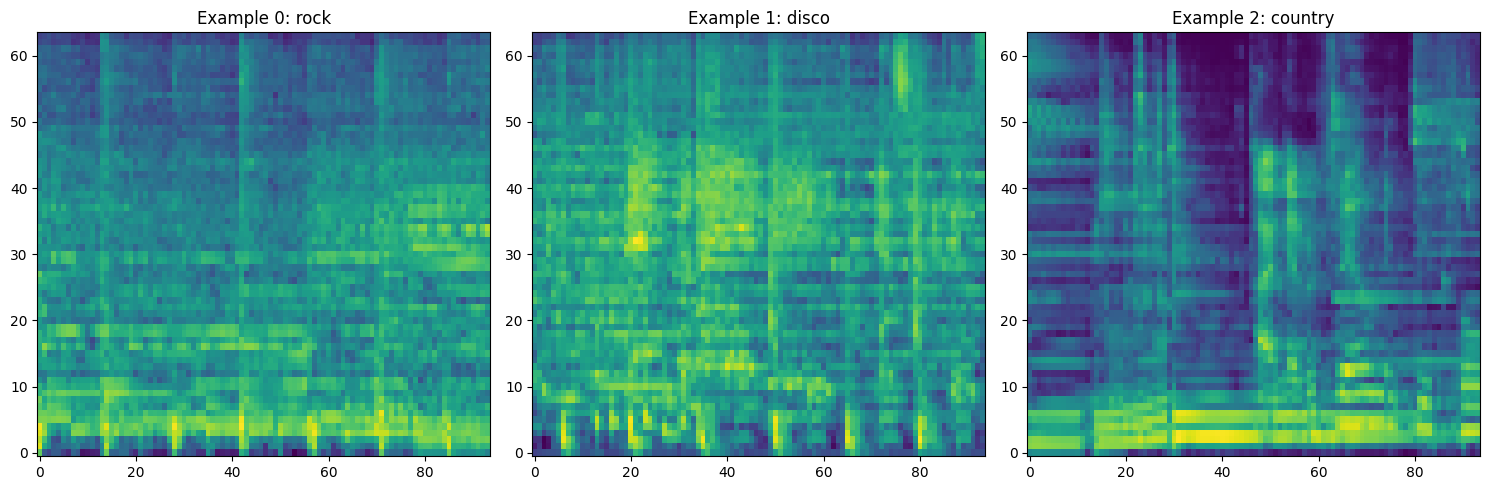

In [9]:
feature_extractor = FeatureExtractor(n_mels=64, n_fft=1024).to(device)

# Fetch a batch of data
batch = next(iter(val_loader))
mel_specs = feature_extractor(batch["audio"]).cpu().numpy()

# Visualize the first three mel-spectrograms in the batch
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(mel_specs[i], aspect="auto", origin="lower")
    axes[i].set_title(f"Example {i}: {batch['natural_labels'][i]}")

plt.tight_layout()
plt.show()

In [11]:
n_classes = len(set(val_dataset.natural_labels.values()))

print("Mel-spectrogram shape:", mel_specs.shape)
print("Number of classes:", n_classes)

Mel-spectrogram shape: (32, 64, 94)
Number of classes: 10


In [51]:
class Transformer(nn.Module):
    """Transformer model for audio classification.

    Args:
        kernel (tuple, optional): Kernel size for the convolutional patch embedding. Defaults to (8, 8).
        stride (tuple, optional): Stride for the convolutional patch embedding. Defaults to (8, 8).
        n_blocks (int, optional): Number of Transformer encoder blocks. Defaults to 2.
        emb_dim (int, optional): Embedding dimension. Defaults to 128.
        n_heads (int, optional): Number of attention heads. Defaults to 2.
        mlp_ratio (int, optional): Ratio of MLP hidden dimension to embedding dimension. Defaults to 2.
        output_size (int, optional): Number of output classes. Defaults to 10.
    """

    def __init__(
        self,
        kernel: tuple = (8, 8),
        stride: tuple = (8, 8),
        n_blocks: int = 2,
        emb_dim: int = 128,
        n_heads: int = 2,
        mlp_ratio: int = 2,
        output_size: int = 10,
        pos_enc_gain: float = 0.0,
        cls_token_ratio: float = 0.0,
    ):
        super().__init__()

        self.n_blocks = n_blocks
        self.emb_dim = emb_dim
        self.n_heads = n_heads
        self.mlp_ratio = mlp_ratio
        self.output_size = output_size
        self.pos_enc_gain = pos_enc_gain
        self.cls_token_ratio = cls_token_ratio

        self.norm = nn.BatchNorm2d(1)

        padding = kernel[0] // 2
        self.patching = nn.Conv2d(
            1, self.emb_dim, kernel_size=kernel, stride=stride, padding=padding
        )

        self.blocks = nn.ModuleList([
          nn.TransformerEncoderLayer(
              self.emb_dim,
              self.n_heads,
              dim_feedforward=self.emb_dim * self.mlp_ratio,
              dropout=0.1,
              norm_first=True,
          ) for _ in range(self.n_blocks)])

        self.cls = nn.Parameter(torch.randn(1, 1, self.emb_dim))

        nn.init.normal_(self.cls, std=0.02)

        self.fc1 = nn.Linear(self.emb_dim, self.emb_dim)
        self.fc2 = nn.Linear(self.emb_dim, self.output_size)

    def positional_encoding(self, seq_len):
        position = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, self.emb_dim, 2, dtype=torch.float32) * -(math.log(10000.0) / self.emb_dim))

        pe = torch.zeros(seq_len, self.emb_dim, device=self.cls.device)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x):
        # Add embedding dimension
        x = x.unsqueeze(1)

        # Normalize input to zero-mean unit std.
        x = self.norm(x)

        # Divide the signal into patches
        x = self.patching(x)  # [B, 1, freq, time] -> [b, E, M, T]

        B, E, M, T = x.shape

        # Generate positional encodings for frequency and time
        pe_m = self.positional_encoding(M) # (M, E)
        pe_t = self.positional_encoding(T) # (T, E)

        pe_m_reshaped = pe_m.transpose(0, 1).unsqueeze(0).unsqueeze(3) # (1, E, F, 1)
        pe_t_reshaped = pe_t.transpose(0, 1).unsqueeze(0).unsqueeze(2) # (1, E, 1, T)

        # Add positional encoding with small gain.
        x = x + self.pos_enc_gain * (pe_m_reshaped + pe_t_reshaped)

        x = x.flatten(start_dim=2)  # [B, E, F, T] -> [B, E, F * T]
        x = x.swapaxes(1, 2)  # [B, E, F * T] -> [B, F * T, E]

        # Concatenate CLS token
        cls = self.cls.repeat(B, 1, 1)
        x = torch.cat([cls, x], dim=1)

        # Transformer backbone
        for block in self.blocks:
          x = block(x)

        # Classification on top of the CLS + average of the rest of tokens
        x_cls = x[:, 0, :]
        x_mean = x[:, 1:, :].mean(dim=1)
        x = self.cls_token_ratio * x_cls + (1 - self.cls_token_ratio) * x_mean

        # Dense classification head
        x = F.layer_norm(x, (self.emb_dim,))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### Step 3: Train the models
Set up the training loop with loss functions and optimizers.


In [66]:
def step(batch, loss_fn, model, optimizer=None):
    x = batch["audio"].to(device)
    y = batch["labels"].to(device)

    # Forward
    x = feature_extractor(x)
    y_est = model(x)

    # Compute loss
    loss = loss_fn(y_est, y)
    step_loss = loss.item()

    # Compute metrics
    y_est = y_est.softmax(dim=1)
    y_int = torch.argmax(y, dim=1).cpu().numpy()
    y_est_int = torch.argmax(y_est, dim=1).cpu().numpy()

    step_acc = accuracy_score(y_int, y_est_int)

    # Backprop
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return step_loss, step_acc


def train(
    model,
    n_epochs=3,
    lr=0.001,
    device="cuda",
    batch_size=32,
):
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    pbar = trange(n_epochs, desc="Training", total=n_epochs)
    for epoch in range(n_epochs):
        # Training loop

        model.train()
        total_loss, total_acc = 0, 0

        for batch in train_loader:
            step_loss, step_acc = step(batch, loss_fn, model, optimizer)
            total_loss += step_loss
            total_acc += step_acc

        train_loss = total_loss / len(train_loader)
        train_acc = total_acc / len(train_loader)

        # Validation loop
        model.eval()
        total_loss, total_acc = 0, 0

        for batch in val_loader:
            step_loss, step_acc = step(batch, loss_fn, model)
            total_loss += step_loss
            total_acc += step_acc

        val_loss = total_loss / len(val_loader)
        val_acc = total_acc / len(val_loader)

        pbar.set_postfix({
            # "epoch": f"{epoch+1}",
            "train loss": f"{train_loss:.3f}",
            "train acc": f"{train_acc:.3f}",
            "val loss": f"{val_loss:.3f}",
            "val acc": f"{val_acc:.3f}",
        })
        pbar.update(1)


def test(model, device="cuda", batch_size=32):
    # Test loop
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    loss_fn = torch.nn.CrossEntropyLoss()

    model.eval()
    total_loss, total_acc = 0, 0

    for batch in test_loader:
        step_loss, step_acc = step(batch, loss_fn, model)
        total_loss += step_loss
        total_acc += step_acc

    test_loss = total_loss / len(test_loader)
    test_acc = total_acc / len(test_loader)

    print(
        f"test loss: {test_loss:.3f}, "
        + f"test acc: {test_acc:.3f}"
    )

In [72]:
class CNN(nn.Module):
    def __init__(
        self,
        kernel_size: int=3,
        pooling_size: int=4,
        dense_size: int=64,
        n_classes: int=10,
    ):
        super().__init__()
        self.dense_size = dense_size
        self.conv1 = nn.Conv2d(1, dense_size // 4, kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(dense_size // 4, dense_size // 2, kernel_size=kernel_size, stride=1, padding=1)
        self.conv3 = nn.Conv2d(dense_size // 2, dense_size, kernel_size=kernel_size, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=pooling_size, stride=pooling_size)
        self.fc1 = nn.Linear(dense_size, dense_size)
        self.fc2 = nn.Linear(dense_size, n_classes)  # Assuming 10 classes

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: (32, 64, 94) -> (32, 1, 64, 94)
        x = self.pool(F.relu(self.conv1(x)))  # -> (32, 16, 64, 94) -> (32, 16, 16, 23)
        x = self.pool(F.relu(self.conv2(x)))  # -> (32, 32, 16, 23) -> (32, 32, 4, 5)
        x = self.pool(F.relu(self.conv3(x)))  # -> (32, 64, 4, 5) -> (32, 64, 1, 1)

        x = x.view(-1, self.dense_size)   # -> (32, 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

print("\nTraining CNN encoder")

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Transformer Trainable parameters: {num_params}")

train(model, n_epochs=100, device=device, batch_size=64)
test(model)


Training CNN encoder
Transformer Trainable parameters: 28106


Training:   0%|          | 0/100 [00:00<?, ?it/s]

test loss: 1.184, test acc: 0.564


In [74]:
model = Transformer(
    n_blocks=2,
    emb_dim=64,
    n_heads=4,
).to(device)

print("Training Transformer encoder")

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")


train(model, n_epochs=100, device=device, batch_size=32)

print("\n")
test(model)

Training Transformer encoder
Number of trainable parameters: 75980


Training:   0%|          | 0/100 [00:00<?, ?it/s]



test loss: 1.357, test acc: 0.569


In [68]:
model = Transformer(
    n_blocks=2,
    emb_dim=64,
    n_heads=4,
    stride=(4, 4),  # half-overlapped patches
).to(device)

print("Training Transformer encoder")

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")


train(model, n_epochs=100, device=device, batch_size=32)

print("\n")
test(model)

Training Transformer encoder
Number of trainable parameters: 75980


Training:   0%|          | 0/100 [00:00<?, ?it/s]



test loss: 1.322, test acc: 0.537


In [69]:
model = Transformer(
    n_blocks=2,
    emb_dim=64,
    n_heads=4,
    stride=(4, 4),  # half-overlapped patches
    pos_enc_gain=0.5,  # positional encoding
).to(device)

print("Training Transformer encoder")

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")


train(model, n_epochs=100, device=device, batch_size=32)

print("\n")
test(model)

Training Transformer encoder
Number of trainable parameters: 75980


Training:   0%|          | 0/100 [00:00<?, ?it/s]



test loss: 1.204, test acc: 0.624


In [76]:
model = Transformer(
    n_blocks=2,
    emb_dim=64,
    n_heads=4,
    stride=(4, 4),  # half-overlapped patches
    pos_enc_gain=0.5,  # positional encoding
    cls_token_ratio=0.25,  # cls token averaging
).to(device)

print("Training Transformer encoder")

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")


train(model, n_epochs=100, device=device, batch_size=32)

print("\n")
test(model)

Training Transformer encoder
Number of trainable parameters: 75980


Training:   0%|          | 0/100 [00:00<?, ?it/s]



test loss: 1.215, test acc: 0.580
